***
## notebook config

In [1]:
ON_COLAB = False
ASSESS = True

In [2]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade xgboost > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [3]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
    subs_path = "/content/drive/MyDrive/meli2021/subs"
    print("subs_path:", subs_path)
    results_path = "/content/drive/MyDrive/meli2021/results"
    print("results_path:", results_path)
else:
    input_path = "../data"
    print("input_path:", input_path)
    subs_path = "../subs"
    print("subs_path:", subs_path)
    results_path = "../results"
    print("results_path:", results_path)

input_path: ../data
subs_path: ../subs
results_path: ../results


In [4]:
SEED = 19

***

In [5]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
import optuna

import sys
sys.path.append("../utils")
from memory import reduce_mem_usage
from metrics import RMSSE, ranked_probability_score, scoring_function, binarize_predictions
from inventory import InventoryDaysPredictor

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

***
## loading data for assessment

In [6]:
if ASSESS:
    dataset = (
        pd.read_parquet(f"{input_path}/train-m2.parquet")
        .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
        .sort_values(["sku","ds"])
        .reset_index(drop=True)
    )
    
dataset["nrows"] = dataset.groupby("sku")["ds"].transform("count")
print(dataset.sku.nunique())
print(dataset.query("nrows == 30").sku.nunique())

531832
500404


In [7]:
# just for assessment
dataset = (
    dataset
    .query("nrows == 30")
    .query("ds in ('2021-02-01', '2021-03-02')")
    .reset_index(drop=True)
)
print(dataset.sku.nunique())

# skus to remove on validation
skus_to_remove = dataset.query("inventory_days > 30").sku.unique()
dataset = dataset.query("sku not in @skus_to_remove").reset_index(drop=True)
print(dataset.sku.nunique())

500404
272130


In [8]:
dataset["id_lower"] = dataset["inventory_days"].copy() 
dataset["id_upper"] = dataset["inventory_days"].copy()

idx = dataset.query("inventory_days > 30").index
dataset.loc[idx,"id_lower"] = 30
dataset.loc[idx,"id_upper"] = np.inf

In [9]:
train_dset = dataset.query("ds == '2021-02-01'").reset_index(drop=True)
valid_dset = dataset.query("ds == '2021-03-02'").reset_index(drop=True)

print(train_dset.sku.nunique())
print(valid_dset.sku.nunique())

272130
272130


In [10]:
numeric_cols = [
    "current_price",
    "listing_type_classic",
    "listing_type_premium",
    "shipping_logistic_type_fulfillment",
    "shipping_logistic_type_cross_docking",
    "shipping_logistic_type_drop_off",
    "shipping_payment_free_shipping",
    "shipping_payment_paid_shipping",
    "minutes_active",
    "weekday_1",
    "weekday_2",
    "weekday_3",
    "weekday_4",
    "weekday_5",
    "weekday_6",
    "weekday_7",
    "q_mean",
    "q_std",
    "target_stock",   
]
print("number of numeric:", len(numeric_cols))

categs_cols = [
    #"sku",
    "item_domain_id",
    #"item_id",
    #"site_id",
    "product_id",
    #"product_family_id",  
]
print("number of categs", len(categs_cols))

categs_to_encode = [
    #"sku",
    #"item_id",
    #"product_family_id",
]

target = "inventory_days"

input_cols = numeric_cols + categs_cols
print("total feats:", len(input_cols))

number of numeric: 19
number of categs 2
total feats: 21


In [11]:
train_dset.loc[:,categs_cols].nunique()

item_domain_id    7553
product_id        6445
dtype: int64

In [12]:
encoder = ce.CatBoostEncoder()
train_dset[categs_cols] = encoder.fit_transform(train_dset[categs_cols], train_dset.eval("target_stock / inventory_days"))
valid_dset[categs_cols] = encoder.transform(valid_dset[categs_cols])

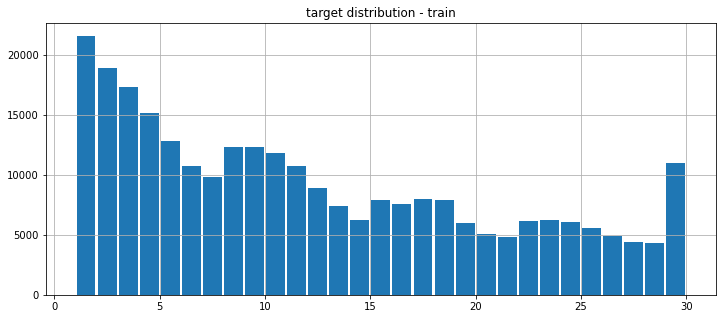

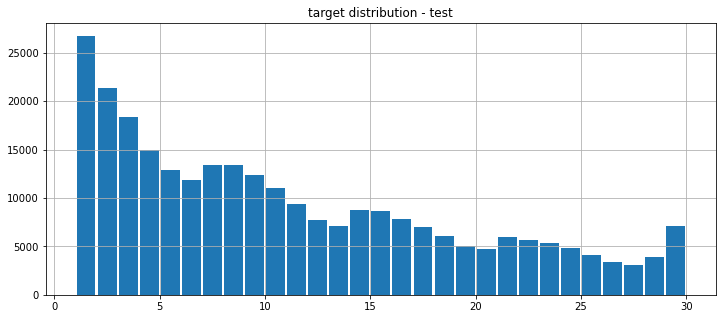

In [13]:
plt.figure(figsize=(12,5))
plt.hist(train_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - train")
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(valid_dset[target].values, bins=np.arange(1,31,1), rwidth=0.9)
plt.title("target distribution - test")
plt.grid()
plt.show()

In [14]:
print("Uncensored rows (train):", len(train_dset.query("inventory_days > 30")) / 1e3)
print("Uncensored rows (valid):", len(valid_dset.query("inventory_days > 30")) / 1e3)

Uncensored rows (train): 0.0
Uncensored rows (valid): 0.0


In [15]:
train_dset.query("sku not in @skus_to_remove").sku.nunique()

272130

***
## loss tuning

In [16]:
model_params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    #'aft_loss_distribution': 'normal',
    #'aft_loss_distribution': 'logistic',
    #'aft_loss_distribution': 'extreme',
    #'aft_loss_distribution_scale': 2.,
    
    #'tree_method': 'exact',
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 256,
    
    'grow_policy': 'lossguide',
    'max_leaves': 2**6-1,
    'min_child_weight': 50,
    'max_depth': 10,
    
    'learning_rate': 0.05,
    'max_delta_step':1.,
    
    'colsample_bytree':0.8,
    'subsample':0.95,
    
    'lambda':0.1,
    'seed':SEED,
}

In [17]:
distributions = ["normal", "logistic", "extreme"]
distributions_scale = np.arange(0.1, 3.01, 0.1)
grid = [(dist,scale) for dist in distributions for scale in distributions_scale]
len(grid)

90

In [20]:
sites = ["MLA","MLB","MLM"]
results = list()

for dist,scale in tqdm(grid):
    
    _model_params = dict(model_params)
    _model_params["aft_loss_distribution"] = dist
    _model_params["aft_loss_distribution_scale"] = scale
    
    oof_preds = list()
    for site in sites:
        _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
        _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)
        sample_index = _train_dset.sample(frac=0.25).index

        dtrain = xgb.DMatrix(
            data = _train_dset.loc[:, numeric_cols+categs_cols], 
        )
        dtrain.set_float_info('label_lower_bound', _train_dset.id_lower.values)
        dtrain.set_float_info('label_upper_bound', _train_dset.id_upper.values)

        dvalid = xgb.DMatrix(
            data = _valid_dset.loc[:, numeric_cols+categs_cols],
        )
        dvalid.set_float_info('label_lower_bound', _valid_dset.id_lower.values)
        dvalid.set_float_info('label_upper_bound', _valid_dset.id_upper.values)

        model = xgb.train(
            params = _model_params,
            dtrain = dtrain,
            evals = [(dvalid,"valid"),],
            num_boost_round = 5000,
            early_stopping_rounds = 50,
            verbose_eval = False,
        )

        _valid_dset["pred"] = model.predict(dvalid)
        oof_preds.append(_valid_dset)
        
    oof_concat = pd.concat(oof_preds, ignore_index=True)
    results.append(oof_concat.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean())

100%|██████████| 90/90 [38:13<00:00, 25.49s/it]


In [21]:
results = pd.DataFrame({"dist-scale":grid, "mae":results})
results.sort_values("mae").head(20)

,dist-scale,mae
46,"(logistic, 1.7000000000000002)",4.727973
43,"(logistic, 1.4000000000000001)",4.728563
21,"(normal, 2.2)",4.729120
45,"(logistic, 1.6)",4.729451
44,"(logistic, 1.5000000000000002)",4.729745
22,"(normal, 2.3000000000000003)",4.729984
18,"(normal, 1.9000000000000001)",4.730029
41,"(logistic, 1.2000000000000002)",4.730180
47,"(logistic, 1.8000000000000003)",4.730467
24,"(normal, 2.5000000000000004)",4.730761


In [22]:
results.sort_values("mae", ascending=False).head(20)

,dist-scale,mae
61,"(extreme, 0.2)",5.763127
62,"(extreme, 0.30000000000000004)",5.759614
63,"(extreme, 0.4)",5.547923
64,"(extreme, 0.5)",5.338475
65,"(extreme, 0.6)",5.194547
60,"(extreme, 0.1)",5.098739
66,"(extreme, 0.7000000000000001)",5.089033
67,"(extreme, 0.8)",5.014779
68,"(extreme, 0.9)",4.965636
69,"(extreme, 1.0)",4.923539


***
## hyperparameters tuning

In [29]:
dist,scale = results.sort_values("mae").head(1)["dist-scale"].values[0]

default_params = dict(model_params)
default_params["aft_loss_distribution"] = dist
default_params["aft_loss_distribution_scale"] = scale

In [30]:
def objective(trial):
    
    sampled_params = {
        # tree structure
        "max_bin" : 2**trial.suggest_int("max_bin", 5, 9),
        "max_leaves" : 2**trial.suggest_int("max_leaves", 4, 9) - 1,
        "min_child_weight" : trial.suggest_int("min_child_weight", 10, 500),
        "max_depth" : trial.suggest_int("max_depth", 5, 12),
        
        # subsampling
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.05),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0, step=0.05),
        
        # regularization
        "max_delta_step" : trial.suggest_float("max_delta_step", 1e-3, 1.0, step=1e-3),
        "lambda" : trial.suggest_float("lambda", 0., 1.0),
        "alpha" : trial.suggest_float("alpha", 0., 1.0),
        "gamma" : trial.suggest_float("gamma", 0., 1.0),
                
        "tree_method" : trial.suggest_categorical("tree_method", ["exact", "approx", "hist"]),
        "grow_policy" : trial.suggest_categorical("grow_policy", ["lossguide", "depthwise"]),
    }
    _model_params = {**default_params, **sampled_params}
    
    
    sites = ["MLA","MLB","MLM"]
    oof_preds = list()

    for site in sites:
        _train_dset = train_dset.query("site_id == @site").reset_index(drop=True)
        _valid_dset = valid_dset.query("site_id == @site").reset_index(drop=True)

        dtrain = xgb.DMatrix(
            data = _train_dset.loc[:, numeric_cols+categs_cols], 
        )
        dtrain.set_float_info('label_lower_bound', _train_dset.id_lower.values)
        dtrain.set_float_info('label_upper_bound', _train_dset.id_upper.values)

        dvalid = xgb.DMatrix(
            data = _valid_dset.loc[:, numeric_cols+categs_cols],
        )
        dvalid.set_float_info('label_lower_bound', _valid_dset.id_lower.values)
        dvalid.set_float_info('label_upper_bound', _valid_dset.id_upper.values)

        model = xgb.train(
            params = _model_params,
            dtrain = dtrain,
            evals = [(dvalid,"valid"),],
            num_boost_round = 5000,
            early_stopping_rounds = 50,
            verbose_eval = False,
        )

        _valid_dset["pred"] = model.predict(dvalid)
        oof_preds.append(_valid_dset)

    oof_concat = pd.concat(oof_preds, ignore_index=True)
    return oof_concat.query("sku not in @skus_to_remove").eval("abs(inventory_days - pred)").mean()
    

In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100000, timeout=14400, n_jobs=1) # 4-hrs

[I 2021-08-27 10:58:17,180] A new study created in memory with name: no-name-8b3b0c56-d47f-441e-9893-85e8440c8f35
[I 2021-08-27 10:59:20,532] Trial 0 finished with value: 4.837312449983316 and parameters: {'max_bin': 9, 'max_leaves': 6, 'min_child_weight': 383, 'max_depth': 10, 'colsample_bytree': 0.75, 'subsample': 0.55, 'max_delta_step': 0.859, 'lambda': 0.8871125538546817, 'alpha': 0.7089922788011118, 'gamma': 0.9574590405043492, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 0 with value: 4.837312449983316.
[I 2021-08-27 11:06:04,288] Trial 1 finished with value: 4.809019542658373 and parameters: {'max_bin': 8, 'max_leaves': 4, 'min_child_weight': 412, 'max_depth': 12, 'colsample_bytree': 0.8500000000000001, 'subsample': 0.7, 'max_delta_step': 0.060000000000000005, 'lambda': 0.9301531353483536, 'alpha': 0.9540983713095026, 'gamma': 0.1871997031995618, 'tree_method': 'approx', 'grow_policy': 'depthwise'}. Best is trial 1 with value: 4.809019542658373.
[I 2021-08

KeyboardInterrupt: 

***